# Simulation

#### Pour la suite de la simluation, la segmentation se fera avec l'algorithme Kmeans, avec les critères 'Frequence',     'Recence',    'Montant',     'review_score'

L'algorithme de segmentation qui à donné les meilleurs résultats est le "Kmeans".













La date de début T0 doit être la plus proche possible de la date de fin du fichier (août 2018), tout en intégrant le délai de simulation de maintenance, non connu au départ. Il faudra donc procéder par itération. Par exemple tester avec T0 au 31/12/2017, et si le délai de maintenance déterminé est de 3 mois (ARI <0.8), refaire une simulation à T0 = août 2018 – tout les mois, pour finir la simulation courant août au plus près de la date du fichier complet.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import time
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_olivetti_faces
from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from matplotlib import offsetbox
from yellowbrick.cluster import KElbowVisualizer
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer, make_column_transformer
from scipy.spatial.distance import cdist
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.preprocessing import FunctionTransformer

In [2]:
clients = pd.read_csv('clients.csv')
clients

,customer_unique_id,Recence,Frequence,Montant,review_score,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90,5.0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19,4.0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,536.0,1,86.22,3.0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,43.62,4.0,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,196.89,5.0,2017-11-14 19:45:42
...,...,...,...,...,...,...
92750,fffcf5a5ff07b0908bd4e2dbc735a684,446.0,1,4134.84,5.0,2017-06-08 21:00:36
92751,fffea47cd6d3cc0a88bd621562a9d061,261.0,1,84.58,4.0,2017-12-10 20:07:56
92752,ffff371b4d645b6ecea244b27531430a,567.0,1,112.46,5.0,2017-02-07 15:49:16
92753,ffff5962728ec6157033ef9805bacc48,118.0,1,133.69,5.0,2018-05-02 15:17:41


In [3]:
clients_flt = clients.select_dtypes(include=["float"])

In [4]:
client_rfm = clients[["Frequence","Recence","Montant"]]

In [3]:
clients = clients.copy()

In [4]:
clients["order_purchase_timestamp"] = pd.to_datetime(clients['order_purchase_timestamp'], 
                                                     format= '%Y-%m-%d %H:%M:%S', errors='coerce')

In [5]:
from datetime import datetime
from datetime import timedelta
clients_date = clients[(clients["order_purchase_timestamp"] < datetime(2017, 12 , 31))]

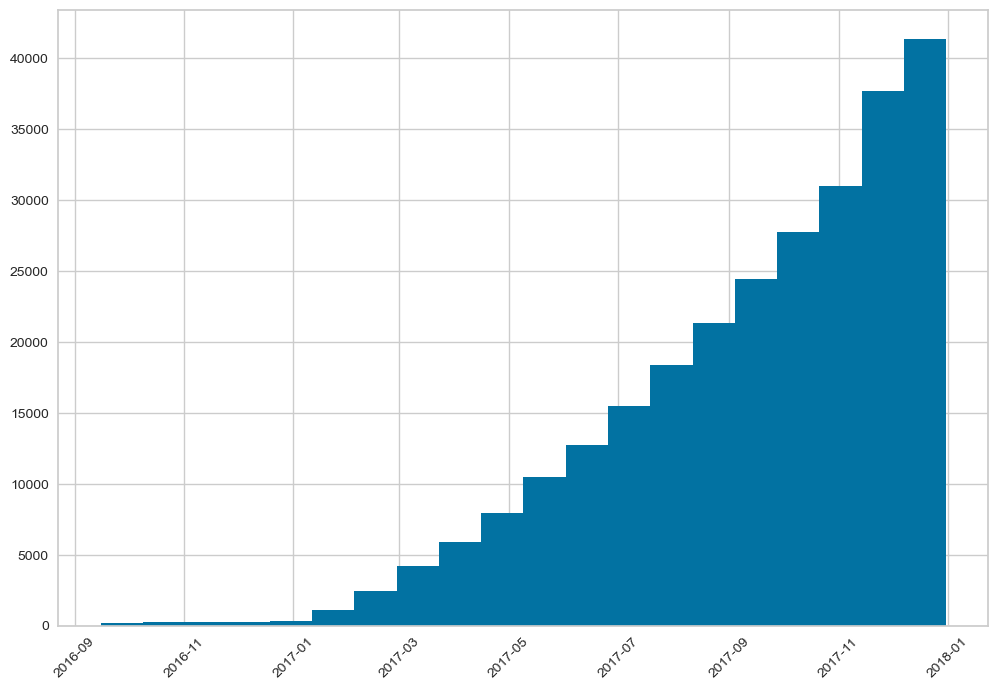

In [6]:
fig=plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
clients_date["order_purchase_timestamp"].hist(bins=20, cumulative= True, density= False)
plt.show()

In [7]:
def calcul_data(endpoint_date, features=["Recence", "Frequence", "Montant"], data=clients):
    data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
    df = data[(data["order_purchase_timestamp"] < endpoint_date)].copy()
    return df[features]

def calcul_M0(data_0):
    sc_0 = StandardScaler().fit(data_0)
    X_0= sc_0.transform(data_0)
    kmeans_0 =  KMeans(n_clusters=4, init='k-means++')
    kmeans_0.fit(X_0)
    return kmeans_0, sc_0

def calcul_label(data):
    X = StandardScaler().fit_transform(data)
    kmeans = KMeans(n_clusters=4, init='k-means++')
    kmeans.fit(X)
    return kmeans.labels_

def simulation_score(endpoint_date, delta_t_weeks=4, features=["Recence", "Frequence", "Montant"], data= clients):
    delta_t = timedelta(weeks=delta_t_weeks)
    N = 10 # nombre de mois 
    data_0 = calcul_data(endpoint_date=endpoint_date , features=features, data= data )
    kmeans_0, sc_0 = calcul_M0(data_0)
    scores, time, dates = [1.],[0.], [endpoint_date]
    for i in range(1, N+1):
        date_i = endpoint_date + delta_t*i
        data_i = calcul_data(date_i, features=features, data= data)
        labels_0i = kmeans_0.predict(sc_0.transform(data_i))
        labels_i=  calcul_label(data_i)
        scores.append(adjusted_rand_score(labels_i, labels_0i))
        time.append(i) 
        dates.append(date_i)
    
    return scores, time, dates

In [8]:
scores, time, dates = simulation_score(endpoint_date=datetime(2017, 12, 31))
scores, dates

([1.0,
  0.8476873460020079,
  0.7470703997988453,
  0.6568395579897227,
  0.6076254693061831,
  0.5558743338142298,
  0.5288506012610352,
  0.5102404150816937,
  0.464053693841165,
  0.3131839303614872,
  0.3132890661085309],
 [datetime.datetime(2017, 12, 31, 0, 0),
  datetime.datetime(2018, 1, 28, 0, 0),
  datetime.datetime(2018, 2, 25, 0, 0),
  datetime.datetime(2018, 3, 25, 0, 0),
  datetime.datetime(2018, 4, 22, 0, 0),
  datetime.datetime(2018, 5, 20, 0, 0),
  datetime.datetime(2018, 6, 17, 0, 0),
  datetime.datetime(2018, 7, 15, 0, 0),
  datetime.datetime(2018, 8, 12, 0, 0),
  datetime.datetime(2018, 9, 9, 0, 0),
  datetime.datetime(2018, 10, 7, 0, 0)])

[Text(0.5, 1.0, 'Evolution du score de Rand')]

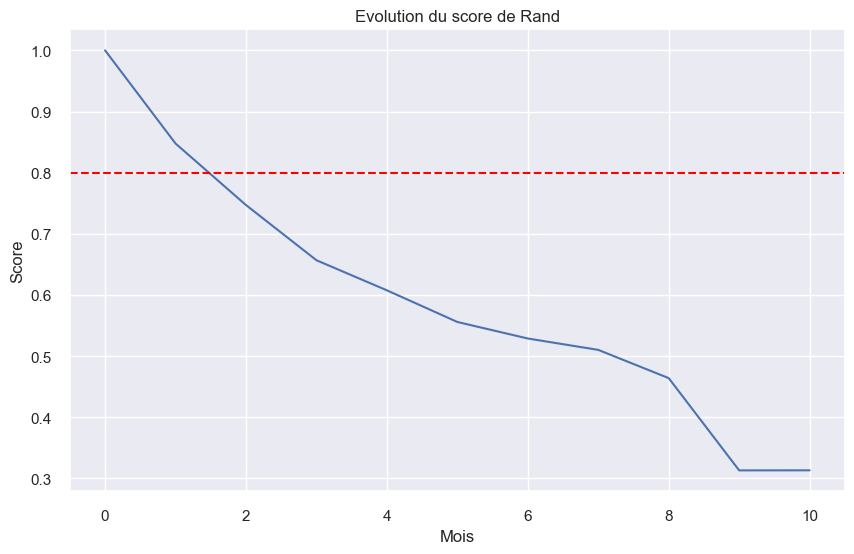

In [9]:
# Evolution du score de Rand
sns.set(rc={'figure.figsize':(10,6)})
fig, ax = plt.subplots()
ax.plot(time, scores)
ax.set_xlabel("Mois")
ax.set_ylabel("Score")
ax.axhline(0.8, c='red', ls='--')
ax.set(title='Evolution du score de Rand')

# Calcul de la simulation en faisant plusieurs itération RFM de chaque mois 

In [10]:
data = pd.read_csv("simulation.csv")
data

,customer_unique_id,order_id,order_purchase_timestamp,payment_installments,payment_value,review_score,payment_type,nombre_jour_depuis_commande,Recence
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,8.0,141.90,5.0,credit_card,111,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,1.0,27.19,4.0,credit_card,114,114
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,8.0,86.22,3.0,credit_card,536,536
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,4.0,43.62,4.0,credit_card,320,320
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,6.0,196.89,5.0,credit_card,287,287
...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,10.0,4134.84,5.0,credit_card,446,446
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,1.0,84.58,4.0,credit_card,261,261
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,1.0,112.46,5.0,credit_card,567,567
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,5.0,133.69,5.0,credit_card,118,118


In [11]:
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

In [12]:
def calculate_rfm(dataframe, ref_date):
    """
    je calcule le RFM à partir du DataFrame "simulation" pour les achats effectués avant une date de référence
    ensuite j'itère sur des périodes de 1 mois à partir de la date de référence et je recalcule le RFM pour chaque période
    je retourne un dictionnaire DataFrame contenant les RFM calculés pour chaque période
   """

  
    dataframe['order_purchase_timestamp'] = pd.to_datetime(dataframe['order_purchase_timestamp'])
    ref_date = pd.to_datetime(ref_date)

    df = dataframe[dataframe['order_purchase_timestamp'] < ref_date]

    # je calcule les scores RFM pour la période de référence
    rfm = df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': lambda x: (ref_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'
    })
    rfm.columns = ['recency', 'frequency', 'monetary']

    # j'initialise le dictionnaire de résultats
    ref_date_str = ref_date.strftime('%Y-%m-%d')
    rfm_dict = {ref_date_str: rfm}

    # j'itère sur des périodes de 1 mois à partir de la date de référence
    for i in range(1, 11):
        # Calcule la date de fin de la période
        end_date = ref_date + pd.DateOffset(months=i)

        # Sélectionne les transactions effectuées avant la date de fin de la période
        df = dataframe[dataframe['order_purchase_timestamp'] < end_date]

        # Calcule les scores RFM pour la période
        rfm = df.groupby('customer_unique_id').agg({
            'order_purchase_timestamp': lambda x: (end_date - x.max()).days,
            'order_id': 'count',
            'payment_value': 'sum'
        })
        rfm.columns = ['recency', 'frequency', 'monetary']

        # j'ajoute les résultats au dictionnaire
        end_date_str = end_date.strftime('%Y-%m-%d')
        rfm_dict[end_date_str] = rfm

    return rfm_dict



In [13]:
# Je calcule le RFM pour chaque période à partir du 31-12-2017
rfm_dict = calculate_rfm(data, '2017-12-31')

# j'affiche les dataframes RFM pour chaque période avec des titres
rfm_titles = {}
rfm_num = 1
for date, rfm in rfm_dict.items():
    title = f'RFM {rfm_num} ({date})'
    rfm_titles[title] = rfm
    print(title + ':')
    display(rfm)
    rfm_num += 1


RFM 1 (2017-12-31):


,recency,frequency,monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,295,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,79,1,43.62
0004aac84e0df4da2b147fca70cf8255,46,1,196.89
0005e1862207bf6ccc02e4228effd9a0,301,1,150.12
0006fdc98a402fceb4eb0ee528f6a8d4,165,1,29.00
...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,3,1,167.32
fffcf5a5ff07b0908bd4e2dbc735a684,205,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,20,1,84.58


RFM 2 (2018-01-31):


,recency,frequency,monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,326,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,110,1,43.62
0004aac84e0df4da2b147fca70cf8255,77,1,196.89
0005e1862207bf6ccc02e4228effd9a0,332,1,150.12
0006fdc98a402fceb4eb0ee528f6a8d4,196,1,29.00
...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,34,1,167.32
fffcf5a5ff07b0908bd4e2dbc735a684,236,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,51,1,84.58


RFM 3 (2018-02-28):


,recency,frequency,monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,354,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,138,1,43.62
0004aac84e0df4da2b147fca70cf8255,105,1,196.89
0005e1862207bf6ccc02e4228effd9a0,360,1,150.12
0006fdc98a402fceb4eb0ee528f6a8d4,224,1,29.00
...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,62,1,167.32
fffcf5a5ff07b0908bd4e2dbc735a684,264,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,79,1,84.58


RFM 4 (2018-03-31):


,recency,frequency,monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,385,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,169,1,43.62
0004aac84e0df4da2b147fca70cf8255,136,1,196.89
00053a61a98854899e70ed204dd4bafe,30,1,838.36
0005e1862207bf6ccc02e4228effd9a0,391,1,150.12
...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,93,1,167.32
fffcf5a5ff07b0908bd4e2dbc735a684,295,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,110,1,84.58


RFM 5 (2018-04-30):


,recency,frequency,monetary
customer_unique_id,,,
0000f46a3911fa3c0805444483337064,415,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,199,1,43.62
0004aac84e0df4da2b147fca70cf8255,166,1,196.89
0004bd2a26a76fe21f786e4fbd80607f,24,1,166.98
00050ab1314c0e55a6ca13cf7181fecf,9,1,35.38
...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,123,1,167.32
fffcf5a5ff07b0908bd4e2dbc735a684,325,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,140,1,84.58


RFM 6 (2018-05-31):


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,20,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,23,1,27.19
0000f46a3911fa3c0805444483337064,446,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,230,1,43.62
0004aac84e0df4da2b147fca70cf8255,197,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,356,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,171,1,84.58
ffff371b4d645b6ecea244b27531430a,477,1,112.46


RFM 7 (2018-06-30):


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,50,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,53,1,27.19
0000f46a3911fa3c0805444483337064,476,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,260,1,43.62
0004aac84e0df4da2b147fca70cf8255,227,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,386,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,201,1,84.58
ffff371b4d645b6ecea244b27531430a,507,1,112.46


RFM 8 (2018-07-31):


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,81,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,84,1,27.19
0000f46a3911fa3c0805444483337064,507,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,291,1,43.62
0004aac84e0df4da2b147fca70cf8255,258,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,417,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,232,1,84.58
ffff371b4d645b6ecea244b27531430a,538,1,112.46


RFM 9 (2018-08-31):


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,448,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,263,1,84.58
ffff371b4d645b6ecea244b27531430a,569,1,112.46


RFM 10 (2018-09-30):


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,142,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,145,1,27.19
0000f46a3911fa3c0805444483337064,568,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,352,1,43.62
0004aac84e0df4da2b147fca70cf8255,319,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,478,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,293,1,84.58
ffff371b4d645b6ecea244b27531430a,599,1,112.46


RFM 11 (2018-10-31):


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,173,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,176,1,27.19
0000f46a3911fa3c0805444483337064,599,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,383,1,43.62
0004aac84e0df4da2b147fca70cf8255,350,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,509,1,4134.84
fffea47cd6d3cc0a88bd621562a9d061,324,1,84.58
ffff371b4d645b6ecea244b27531430a,630,1,112.46


In [14]:
print(rfm_titles.keys())

dict_keys(['RFM 1 (2017-12-31)', 'RFM 2 (2018-01-31)', 'RFM 3 (2018-02-28)', 'RFM 4 (2018-03-31)', 'RFM 5 (2018-04-30)', 'RFM 6 (2018-05-31)', 'RFM 7 (2018-06-30)', 'RFM 8 (2018-07-31)', 'RFM 9 (2018-08-31)', 'RFM 10 (2018-09-30)', 'RFM 11 (2018-10-31)'])


In [15]:
rfm_0 = pd.DataFrame.from_dict(rfm_titles['RFM 1 (2017-12-31)'])
rfm_1 = pd.DataFrame.from_dict(rfm_titles['RFM 2 (2018-01-31)'])
rfm_2 = pd.DataFrame.from_dict(rfm_titles['RFM 3 (2018-02-28)'])
rfm_3 = pd.DataFrame.from_dict(rfm_titles['RFM 4 (2018-03-31)'])
rfm_4 = pd.DataFrame.from_dict(rfm_titles['RFM 5 (2018-04-30)'])
rfm_5 = pd.DataFrame.from_dict(rfm_titles['RFM 6 (2018-05-31)'])
rfm_6 = pd.DataFrame.from_dict(rfm_titles['RFM 7 (2018-06-30)'])
rfm_7 = pd.DataFrame.from_dict(rfm_titles['RFM 8 (2018-07-31)'])
rfm_8 = pd.DataFrame.from_dict(rfm_titles['RFM 9 (2018-08-31)'])
rfm_9 = pd.DataFrame.from_dict(rfm_titles['RFM 10 (2018-09-30)'])
rfm_10 = pd.DataFrame.from_dict(rfm_titles['RFM 11 (2018-10-31)'])

In [16]:
# model 0 je m'en serre comme base
std_0 = StandardScaler().fit(rfm_0)
date0_std = std_0.transform(rfm_0)
model_0 = KMeans(n_clusters=4).fit(date0_std)

In [17]:
b0_std_0 = std_0.transform(rfm_0)
label_0_0 = model_0.predict(b0_std_0)
b0_std_0 = StandardScaler().fit_transform(rfm_0)
model_0 = KMeans(n_clusters=4).fit(b0_std_0)
label_0_0 = model_0.predict(b0_std_0)

In [18]:
"""
ici je calcule tout les autres modèle, ce code effectue une segmentation de la clientèle 
en deux étapes en utilisant deux modèles Kmeans différents 
pour la première étape, j'utilise le modèle ajusté sur les données de la période précédente c'est à dire model 0 pour prédire 
les étiquettes de cluster pour les données de la période actuelle, puis dans la deuxième étape, 
j'utilise un nouveau modèle ajusté directement sur les données de la période actuelle"""

b1_std_0 = std_0.transform(rfm_1)
label_1_0 = model_0.predict(b1_std_0)
b1_std_1 = StandardScaler().fit_transform(rfm_1)
model_1 = KMeans(n_clusters=4).fit(b1_std_1)
label_1_1 = model_1.predict(b1_std_1)


b2_std_0 = std_0.transform(rfm_2)
label_2_0 = model_0.predict(b2_std_0)
b2_std_2 = StandardScaler().fit_transform(rfm_2)
model_2 = KMeans(n_clusters=4).fit(b2_std_2)
label_2_2 = model_2.predict(b2_std_2)

b3_std_0 = std_0.transform(rfm_3)
label_3_0 = model_0.predict(b3_std_0)
b3_std_3 = StandardScaler().fit_transform(rfm_3)
model_3 = KMeans(n_clusters=4).fit(b3_std_3)
label_3_3 = model_3.predict(b3_std_3)

b4_std_0 = std_0.transform(rfm_4)
label_4_0 = model_0.predict(b4_std_0)
b4_std_4 = StandardScaler().fit_transform(rfm_4)
model_4 = KMeans(n_clusters=4).fit(b4_std_4)
label_4_4 = model_4.predict(b4_std_4)

b5_std_0 = std_0.transform(rfm_5)
label_5_0 = model_0.predict(b5_std_0)
b5_std_5 = StandardScaler().fit_transform(rfm_5)
model_5 = KMeans(n_clusters=4).fit(b5_std_5)
label_5_5 = model_5.predict(b5_std_5)

b6_std_0 = std_0.transform(rfm_6)
label_6_0 = model_0.predict(b6_std_0)
b6_std_6 = StandardScaler().fit_transform(rfm_6)
model_6 = KMeans(n_clusters=4).fit(b6_std_6)
label_6_6 = model_6.predict(b6_std_6)

b7_std_0 = std_0.transform(rfm_7)
label_7_0 = model_0.predict(b7_std_0)
b7_std_7 = StandardScaler().fit_transform(rfm_7)
model_7 = KMeans(n_clusters=4).fit(b7_std_7)
label_7_7 = model_7.predict(b7_std_7)

b8_std_0 = std_0.transform(rfm_8)
label_8_0 = model_0.predict(b8_std_0)
b8_std_8 = StandardScaler().fit_transform(rfm_8)
model_8 = KMeans(n_clusters=4).fit(b8_std_8)
label_8_8 = model_8.predict(b8_std_8)

b9_std_0 = std_0.transform(rfm_9)
label_9_0 = model_0.predict(b9_std_0)
b9_std_9 = StandardScaler().fit_transform(rfm_9)
model_9 = KMeans(n_clusters=4).fit(b9_std_9)
label_9_9 = model_9.predict(b9_std_9)

b10_std_0 = std_0.transform(rfm_10)
label_10_0 = model_0.predict(b10_std_0)
b10_std_10 = StandardScaler().fit_transform(rfm_10)
model_10 = KMeans(n_clusters=4).fit(b10_std_10)
label_10_10 = model_10.predict(b10_std_10)

In [19]:
ari_0_0 = adjusted_rand_score(label_0_0,label_0_0)
ari_0_1 = adjusted_rand_score(label_1_0,label_1_1)
ari_0_2 = adjusted_rand_score(label_2_0,label_2_2)
ari_0_3 = adjusted_rand_score(label_3_0,label_3_3)
ari_0_4 = adjusted_rand_score(label_4_0,label_4_4)
ari_0_5 = adjusted_rand_score(label_5_0,label_5_5)
ari_0_6 = adjusted_rand_score(label_6_0,label_6_6)
ari_0_7 = adjusted_rand_score(label_7_0,label_7_7)
ari_0_8 = adjusted_rand_score(label_8_0,label_8_8)
ari_0_9 = adjusted_rand_score(label_9_0,label_9_9)
ari_0_10 = adjusted_rand_score(label_10_0,label_10_10)

In [20]:
ari_0_0,ari_0_1, ari_0_2, ari_0_3, ari_0_4, ari_0_5, ari_0_6, ari_0_7, ari_0_8, ari_0_9, ari_0_10

(1.0,
 0.894547773540428,
 0.7728537251814266,
 0.6713919638113693,
 0.5193508660641806,
 0.38713828387399357,
 0.29289771261616404,
 0.20950127706523425,
 0.2850719621643372,
 0.15160158199618146,
 0.0572496576600719)

[Text(0.5, 1.0, 'Evolution du score de Rand')]

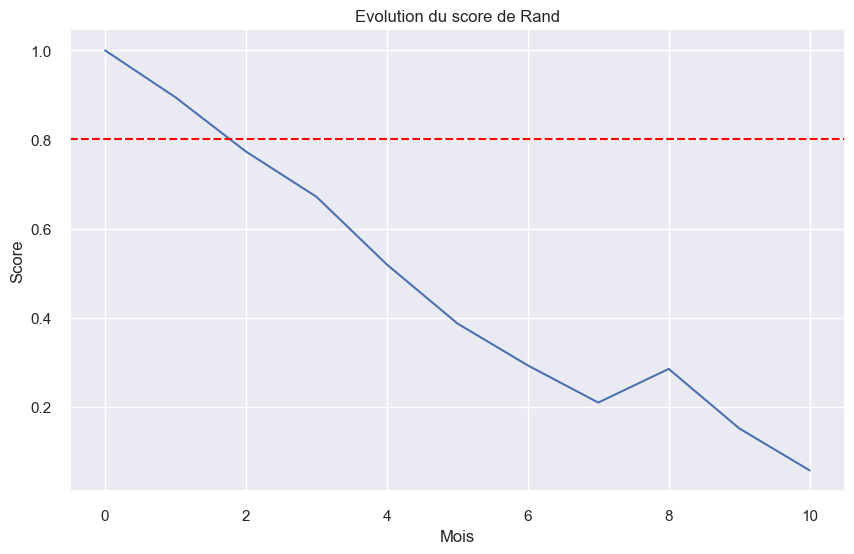

In [21]:
# Evolution du score de Rand
sns.set(rc={'figure.figsize':(10,6)})
fig, ax = plt.subplots()
ax = sns.lineplot(x=range(0,11), y =[ari_0_0,ari_0_1, ari_0_2, ari_0_3, ari_0_4, ari_0_5,
                                    ari_0_6, ari_0_7, ari_0_8, ari_0_9, ari_0_10])
ax.set_xlabel("Mois")
ax.set_ylabel("Score")
ax.axhline(0.8, c='red', ls='--')
ax.set(title='Evolution du score de Rand')

Donc au bout de 1 mois et demi sois 6 semaine environ le modèle devient obsolète 